# Extracting, Loading, and Transforming Data from an OMOP CDM Database with EHRData
ehrdata is a flexible data structure which supports useful operations to read the OMOP CDM standard.
ehrdata hosts a suite of functions required to process this data for machine learning models.

data in the ehrdata format enables to use and leverage ehrapy's many exploratory analysis functionalities.

## OMOP
[OMOP](https://ohdsi.github.io/CommonDataModel/index.html) is a data model by [OHDSI](https://www.ohdsi.org/).

## Demo
### MIMIC IV OMOP Demo Dataset
Dataset available on [Physionet](https://physionet.org/content/mimic-iv-demo-omop/0.9/).

It describes ... .

Dataset:<br>
Kallfelz, M., Tsvetkova, A., Pollard, T., Kwong, M., Lipori, G., Huser, V., Osborn, J., Hao, S., & Williams, A. (2021). MIMIC-IV demo data in the OMOP Common Data Model (version 0.9). PhysioNet. https://doi.org/10.13026/p1f5-7x35.

Physionet:<br>
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

### Extract
Download data by zip or CLI.

### Load
Many backends are supported by ehrapy.
It is probably a good idea to have the data stored in a RDBMS.

Here, we use [duckdb](https://duckdb.org/)'s Python API to load csv tables as they are available from the link above. (which is absolutely useless for immediate purposes but why not)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import duckdb
import ehrapy as ep
import numpy as np

omop_table_path = "/Users/eljas.roellin/Documents/ehrapy_workspace/mimic-iv-demo-data-in-the-omop-common-data-model-0.9/1_omop_data_csv"

duckdb.register("person", duckdb.read_csv(f"{omop_table_path}/person.csv"))
duckdb.register(
    "measurement", duckdb.read_csv(f"{omop_table_path}/measurement.csv", dtype={"measurement_source_value": "VARCHAR"})
)
duckdb.register("observation_period", duckdb.read_csv(f"{omop_table_path}/observation_period.csv"))

### Transform
ehrapy allows many reproducible, documented transformation steps to get data from its backend into formats that are
- useful for machine learning (sklearn & pypots)
- useful for exploratory analysis (ehrapy suite)
- useful for visualization (vitessce ehrapyviewer)



In [ ]:
# https://physionet.org/static/published-projects/mimic-iv-demo-omop/mimic-iv-demo-data-in-the-omop-common-data-model-0.9.zip

In [3]:
from dummy_ehrdata import DummyEHRData

edata = DummyEHRData(backend="duckdb")

edata.extract_person(duckdb_instance=duckdb)

edata.obs.head()

ModuleNotFoundError: No module named 'dummy_ehrdata'

##### Interlude - Irregularly sampled time series data
Electronic health records can be regarded as (that is, form a model of a person via) irregular sampling irregularly sampled time series.

Following notation and explanation from [Horn et al.](https://proceedings.mlr.press/v119/horn20a.html), a time series of a patient can be described as a set of tuples (t, z, m), where t denotes the time, z the observed value, and m a modality description of the measurement.

The time series can have different lengths, and a "typical" number of observed values might not exist.

Generally, an irregularly-sampled time series can be converted into a missing data problem by discretizing the time axis into non-overlapping intervals, and declaring intervals in which no data was sampled as missing (Bahadori & Lipton, 2019). [Horn et al.](https://proceedings.mlr.press/v119/horn20a.html).

EHRData's extract_XXXX extracts irregularly sampled time series from OMOP tables XXX.

TODO add illustration

EHRData's time_interval_table transforms this into the missing data problem with discretized time axis.

TODO add illustration


In [4]:
edata.extract_measurement(duckdb_instance=duckdb)

In [5]:
edata.ts[0][1]

<Array [[-1, 3, 2, 0, 0, 3, 1], [...]] type='2 * var * union[float64, datet...'>

In [ ]:
# create interval table
edata.time_interval_table(
    duckdb_instance=duckdb,
    start_time="patient_hospital_entry",  # TODO: sync with omop lingo; that could be "cohort index date", but maybe is something different. Ref: https://ohdsi.github.io/TheBookOfOhdsi/Cohorts.html time zero for the time interval matrix
    observation_duration=250,  # in d, time end for the time interval matrix
    concept_ids="all",  # features to use
    interval_length=1,  # length of the time intervals
    interval_unit="minutes",  # unit of the time intervals
)

In [13]:
# n_patients x n_intervals x n_features
np.array(edata.it).shape

### EDA
#### CohortTracker

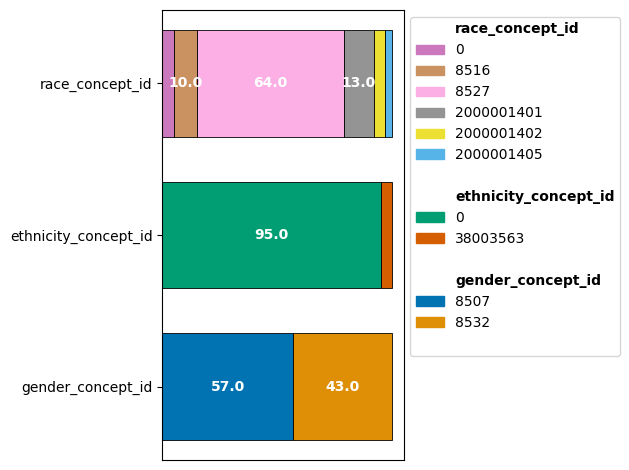

In [28]:
import anndata as ad

edata_as_anndata = ad.AnnData(X=np.zeros_like(edata.obs), obs=edata.obs)
ct = ep.tl.CohortTracker(
    edata_as_anndata,
    columns=["gender_concept_id", "ethnicity_concept_id", "race_concept_id"],
    categorical=["gender_concept_id", "ethnicity_concept_id", "race_concept_id"],
)
ct(edata_as_anndata)
ct.plot_cohort_barplot()

#### Missing Values

<Axes: >

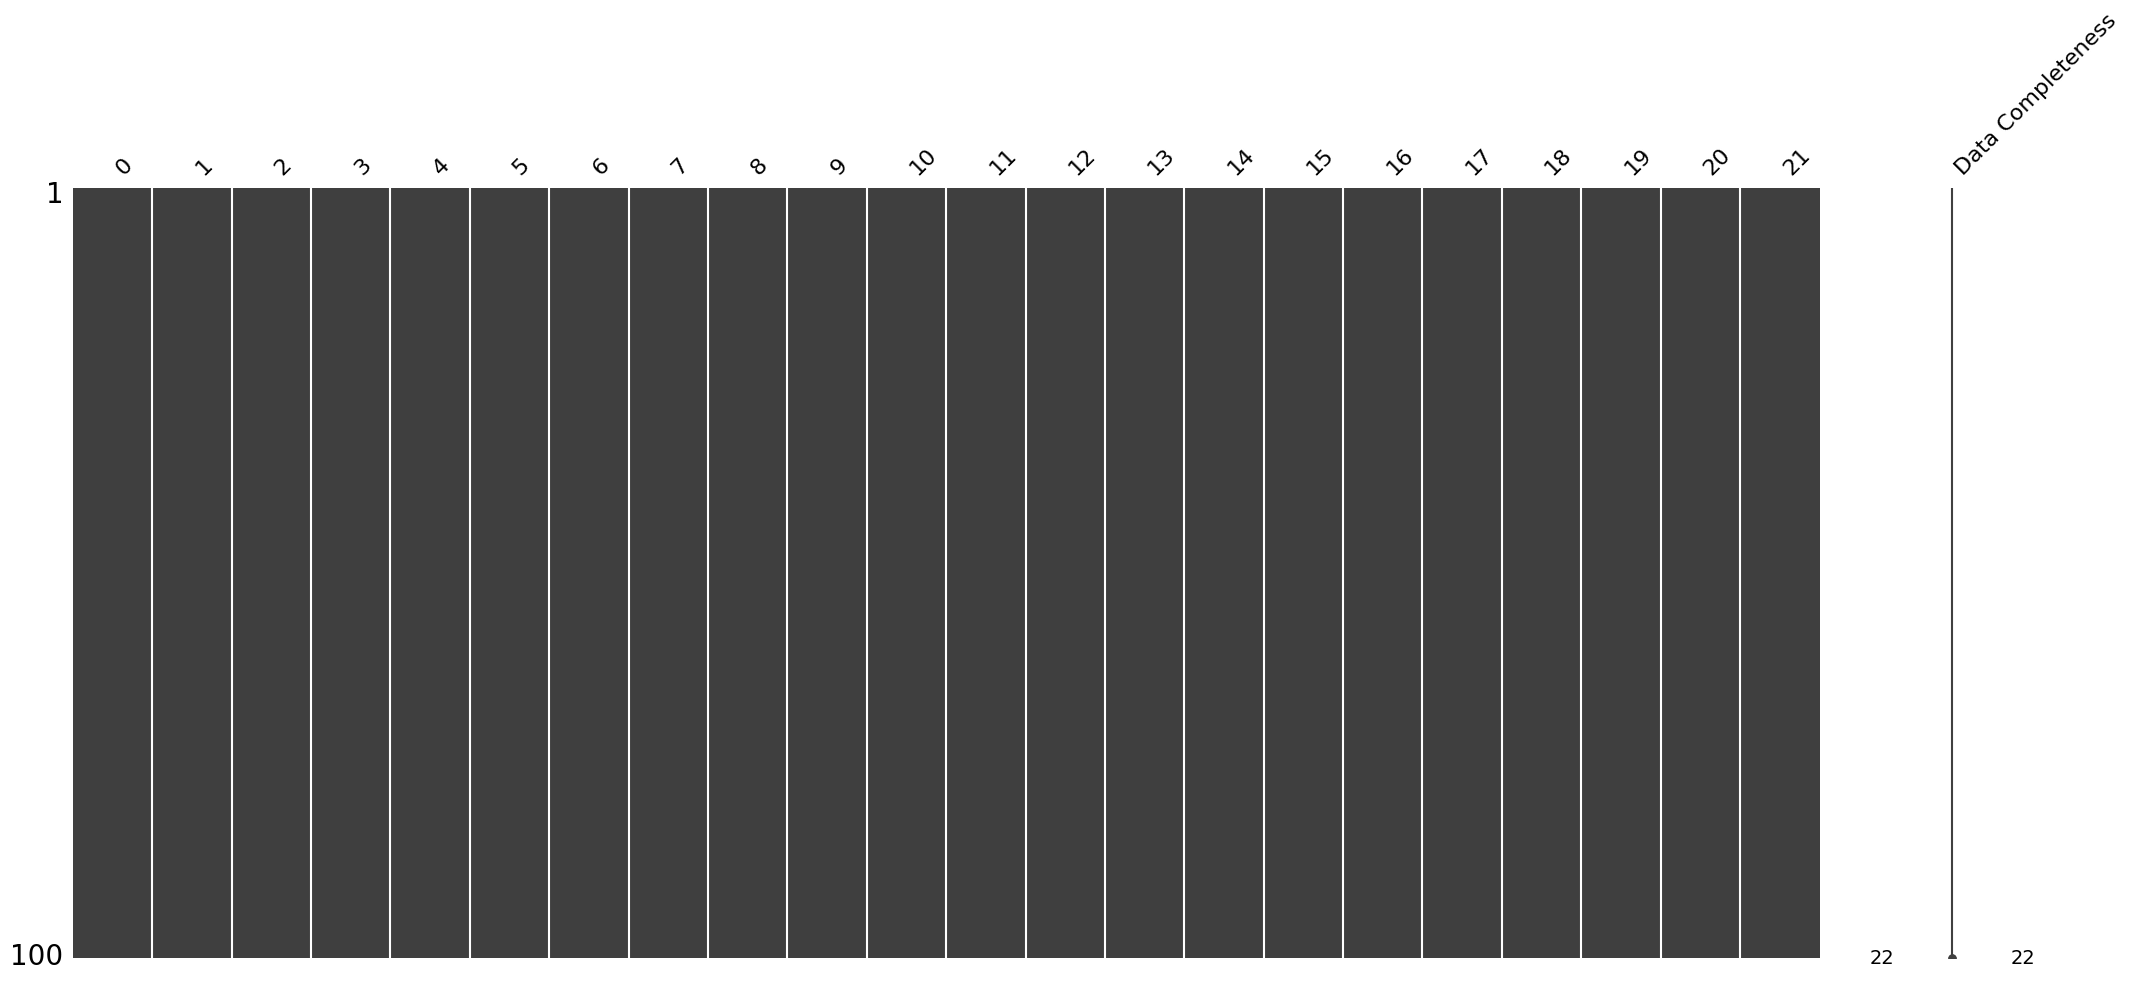

In [31]:
ep.pl.missing_values_matrix(edata_as_anndata)  # TODO: also time series?

### Machine Learning
Ehrapy seamlessly integrates with machine learning libraries such as sklearn, or dedicated time series ML libraries like pypots.

#### PyPOTS impute or classify?
See [PyPOTS](https://docs.pypots.com/en/latest/examples.html) which operates on the time interval table generated by ehrapy.

```
!pip install pypots
```

In [35]:
from pypots.imputation import SAITS

In [42]:
# initialize the model
saits = SAITS(
    n_steps=11,
    n_features=450,
    n_layers=2,
    d_model=256,
    d_ffn=128,
    n_heads=4,
    d_k=64,
    d_v=64,
    dropout=0.1,
    epochs=3,
    saving_path="examples/saits",  # set the path for saving tensorboard logging file and model checkpoint
    model_saving_strategy="best",  # only save the model with the best validation performance
)

2024-08-23 14:11:30 [INFO]: No given device, using default device: cpu
2024-08-23 14:11:30 [INFO]: Model files will be saved to examples/saits/20240823_T141130
2024-08-23 14:11:30 [INFO]: Tensorboard file will be saved to examples/saits/20240823_T141130/tensorboard
2024-08-23 14:11:30 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 2,419,814


In [43]:
saits.fit({"X": np.array(edata.it)})
imputation = saits.impute({"X": np.array(edata.it)})

2024-08-23 14:11:32 [INFO]: Epoch 001 - training loss: 153.7664
2024-08-23 14:11:32 [INFO]: Saved the model to examples/saits/20240823_T141130/SAITS_epoch1_loss153.76637649536133.pypots
2024-08-23 14:11:32 [INFO]: Epoch 002 - training loss: 162.0959
2024-08-23 14:11:32 [INFO]: Epoch 003 - training loss: 163.6547
2024-08-23 14:11:32 [INFO]: Finished training. The best model is from epoch#1.
2024-08-23 14:11:32 [INFO]: Saved the model to examples/saits/20240823_T141130/SAITS.pypots


In [44]:
imputation

array([[[ 3.8334923e+00,  7.4824512e-02,  5.3885984e+00, ...,
         -1.9672710e-01,  1.2278686e+00,  1.7606061e+00],
        [ 3.8192391e+00,  6.5954238e-02,  5.4974842e+00, ...,
         -2.4046504e-01,  1.2477617e+00,  1.7412457e+00],
        [ 3.8143442e+00,  6.5979809e-02,  5.4906402e+00, ...,
         -2.4437267e-01,  1.2481689e+00,  1.7394999e+00],
        ...,
        [ 3.8215313e+00,  6.6506460e-02,  5.4998322e+00, ...,
         -2.4562079e-01,  1.2484723e+00,  1.7375542e+00],
        [ 3.8182511e+00,  6.6276051e-02,  5.4884953e+00, ...,
         -2.4466354e-01,  1.2491769e+00,  1.7389424e+00],
        [ 3.8367624e+00,  1.0000000e+00,  4.6991825e+00, ...,
         -2.5309700e-01,  1.3787152e+00,  1.6633894e+00]],

       [[ 3.8513041e+00,  4.3666318e-02,  5.3734140e+00, ...,
         -2.1152657e-01,  1.2032628e+00,  1.7398019e+00],
        [ 4.1300000e+02, -1.5000000e+01,  4.5032616e+00, ...,
         -3.3774734e-01,  1.4340875e+00,  1.6339254e+00],
        [ 4.1300000e+02, 

can also get representation: e.g. raindrop. prob. should do also for viz. below.

### Visualization
Now that data is in ehrdata, ehrapy's ecosystem vizualization options are available.

#### Vitessce

In [ ]:
# import vitessce
# set config
# show in notebook and refer to deposited viz on lamin